# 📊 GMM Regime Detection

**Objectif** : Explorer les régimes macro avec Gaussian Mixture Model
- Comparer les recettes (baseline_z vs z_plus_momentum)
- Choisir le nombre optimal de régimes K (BIC/AIC)
- Valider que les clusters ont du sens économique


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

ROOT = Path("/Users/etienne/Documents/Git/macro-dynamics")
RANDOM_STATE = 42


## 1. Charger les données


In [2]:
# Charger les deux recettes principales
df_baseline = pd.read_parquet(ROOT / "data/features/baseline_z.parquet")
df_momentum = pd.read_parquet(ROOT / "data/features/z_plus_momentum.parquet")

print(f"📊 baseline_z: {df_baseline.shape}")
print(f"📊 z_plus_momentum: {df_momentum.shape}")
print(f"\nPériode: {df_baseline.index.min()} → {df_baseline.index.max()}")


📊 baseline_z: (359, 23)
📊 z_plus_momentum: (359, 39)

Période: 1996-01-31 00:00:00 → 2025-11-28 00:00:00


In [3]:
# Features z-scorées uniquement (pour GMM)
z_cols = [c for c in df_baseline.columns if c.endswith('_Z')]
print(f"Features Z-score ({len(z_cols)}): {z_cols}")

# Features momentum (pour z_plus_momentum)
momentum_cols = [c for c in df_momentum.columns if c.endswith(('_D1M', '_D6M', '_DD_12M'))]
print(f"\nFeatures momentum ({len(momentum_cols)}): {momentum_cols}")


Features Z-score (11): ['US10Y_Z', 'US2Y_Z', 'HY_OAS_Z', 'IG_OAS_Z', 'INFLATION_EXP_Z', 'PMI_GAP_Z', 'Unemployment_Z', 'VIX_Z', 'CREDIT_SPREAD_Z', 'Confidence_Z', 'YC_SLOPE_Z']

Features momentum (15): ['SPX_DD_12M', 'US10Y_D1M', 'US10Y_D6M', 'HY_OAS_D1M', 'HY_OAS_D6M', 'INFLATION_EXP_D1M', 'INFLATION_EXP_D6M', 'PMI_GAP_D1M', 'PMI_GAP_D6M', 'Unemployment_D1M', 'Unemployment_D6M', 'VIX_D1M', 'VIX_D6M', 'Confidence_D1M', 'Confidence_D6M']


In [4]:
# Préparer les datasets pour GMM
X_baseline = df_baseline[z_cols].values
X_momentum = df_momentum[z_cols + momentum_cols].values

# Normaliser le momentum dataset (les diffs ne sont pas z-scorés)
scaler = StandardScaler()
X_momentum_scaled = scaler.fit_transform(X_momentum)

print(f"X_baseline: {X_baseline.shape}")
print(f"X_momentum_scaled: {X_momentum_scaled.shape}")


X_baseline: (359, 11)
X_momentum_scaled: (359, 26)


## 2. Sélection du nombre de régimes K (BIC/AIC)


In [5]:
def evaluate_gmm_k(X: np.ndarray, k_range: range, name: str) -> pd.DataFrame:
    """Évalue GMM pour différentes valeurs de K."""
    results = []
    
    for k in k_range:
        gmm = GaussianMixture(
            n_components=k,
            covariance_type='full',
            n_init=10,
            random_state=RANDOM_STATE
        )
        gmm.fit(X)
        labels = gmm.predict(X)
        
        results.append({
            'k': k,
            'bic': gmm.bic(X),
            'aic': gmm.aic(X),
            'silhouette': silhouette_score(X, labels) if k > 1 else 0,
            'calinski': calinski_harabasz_score(X, labels) if k > 1 else 0,
            'log_likelihood': gmm.score(X) * len(X),
        })
    
    df_results = pd.DataFrame(results)
    df_results['dataset'] = name
    return df_results


In [6]:
# Évaluer pour K = 2 à 8
k_range = range(2, 9)

results_baseline = evaluate_gmm_k(X_baseline, k_range, 'baseline_z')
results_momentum = evaluate_gmm_k(X_momentum_scaled, k_range, 'z_plus_momentum')

df_results = pd.concat([results_baseline, results_momentum])
df_results


,k,bic,aic,silhouette,calinski,log_likelihood,dataset
0,2,10422.066508,9820.151538,0.210076,94.349531,-4755.075769,baseline_z
1,3,9545.873282,8641.059166,0.152870,88.330838,-4087.529583,baseline_z
2,4,9329.063196,8121.349933,0.163752,93.441085,-3749.674967,baseline_z
3,5,9290.672457,7780.060048,0.203089,74.142805,-3501.030024,baseline_z
4,6,9092.052890,7278.541334,0.191924,85.853785,-3172.270667,baseline_z
5,7,9109.701533,6993.290831,0.199409,87.487827,-2951.645416,baseline_z
6,8,9020.379913,6601.070065,0.208900,80.209064,-2677.535033,baseline_z
0,2,20588.863124,17656.954721,0.308767,73.139901,-8073.477360,z_plus_momentum
1,3,19948.313878,15548.509612,0.215843,50.645274,-6641.254806,z_plus_momentum
2,4,19628.006561,13760.306432,0.172678,46.742780,-5369.153216,z_plus_momentum


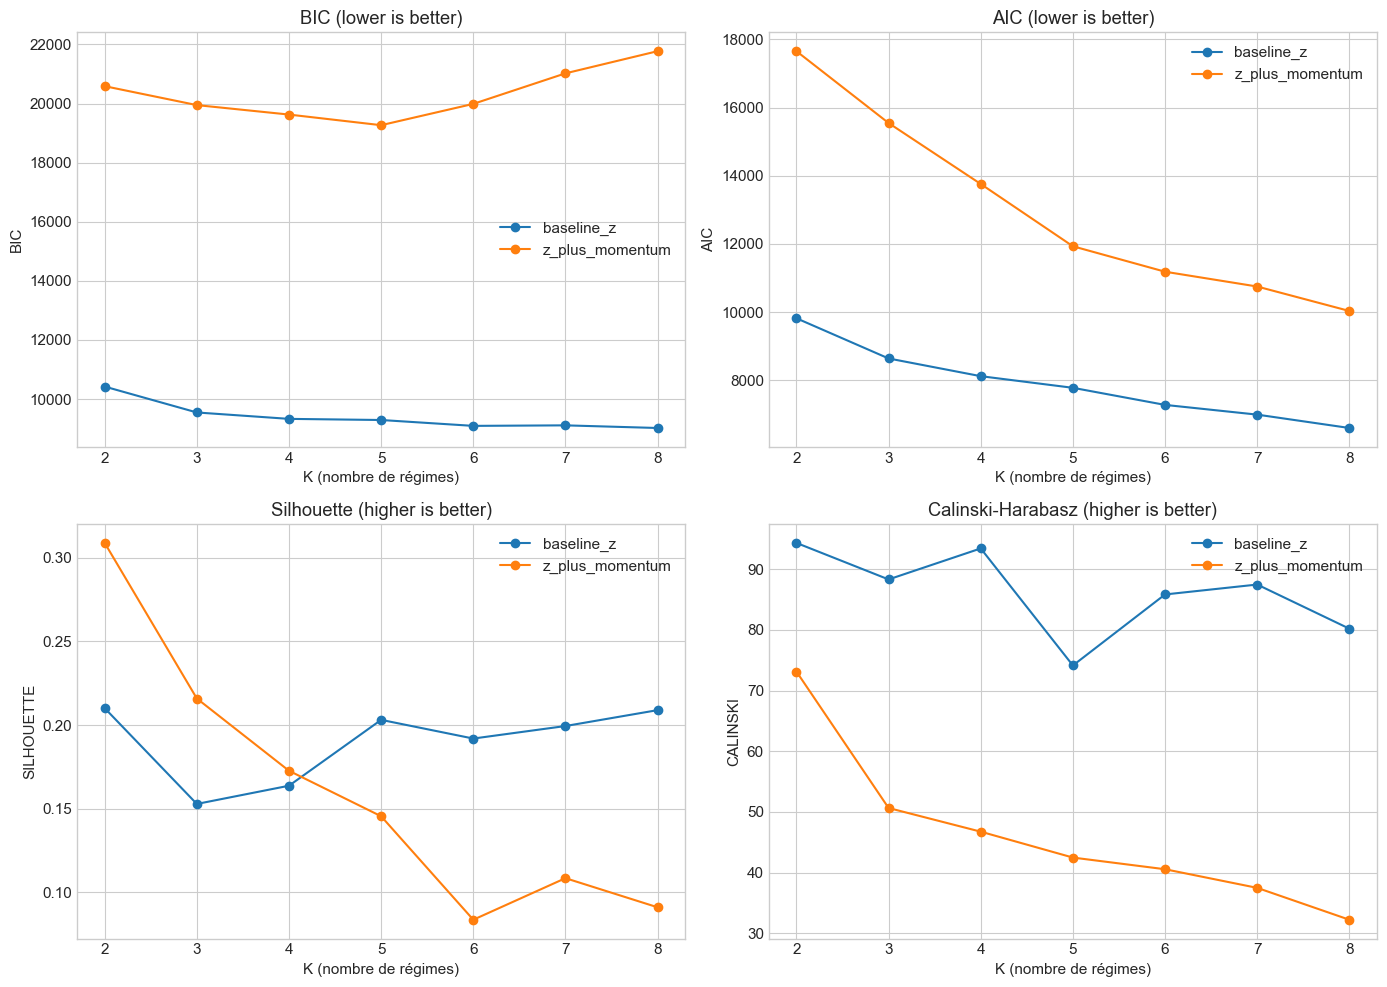

In [7]:
# Visualisation BIC/AIC
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, (metric, title) in enumerate([('bic', 'BIC (lower is better)'), 
                                       ('aic', 'AIC (lower is better)'),
                                       ('silhouette', 'Silhouette (higher is better)'),
                                       ('calinski', 'Calinski-Harabasz (higher is better)')]):
    ax = axes.flat[i]
    for dataset in ['baseline_z', 'z_plus_momentum']:
        data = df_results[df_results['dataset'] == dataset]
        ax.plot(data['k'], data[metric], marker='o', label=dataset)
    ax.set_xlabel('K (nombre de régimes)')
    ax.set_ylabel(metric.upper())
    ax.set_title(title)
    ax.legend()
    ax.set_xticks(list(k_range))

plt.tight_layout()
plt.show()


In [8]:
# Trouver les K optimaux
for dataset in ['baseline_z', 'z_plus_momentum']:
    data = df_results[df_results['dataset'] == dataset]
    k_bic = data.loc[data['bic'].idxmin(), 'k']
    k_aic = data.loc[data['aic'].idxmin(), 'k']
    k_sil = data.loc[data['silhouette'].idxmax(), 'k']
    print(f"\n{dataset}:")
    print(f"  K optimal (BIC): {k_bic}")
    print(f"  K optimal (AIC): {k_aic}")
    print(f"  K optimal (Silhouette): {k_sil}")



baseline_z:
  K optimal (BIC): 8
  K optimal (AIC): 8
  K optimal (Silhouette): 2

z_plus_momentum:
  K optimal (BIC): 5
  K optimal (AIC): 8
  K optimal (Silhouette): 2


## 3. Fit du modèle GMM final


In [9]:
# Choisir K (ajuster après avoir vu les métriques)
K_OPTIMAL = 4

# Fit GMM sur baseline_z
gmm = GaussianMixture(
    n_components=K_OPTIMAL,
    covariance_type='full',
    n_init=20,
    random_state=RANDOM_STATE
)
gmm.fit(X_baseline)

# Prédictions
df_baseline['regime'] = gmm.predict(X_baseline)
df_baseline['regime_proba'] = gmm.predict_proba(X_baseline).max(axis=1)

print(f"✅ GMM fit avec K={K_OPTIMAL}")
print("\nDistribution des régimes:")
print(df_baseline['regime'].value_counts().sort_index())


✅ GMM fit avec K=4

Distribution des régimes:
regime
0    106
1     46
2    123
3     84
Name: count, dtype: int64


## 4. Profils économiques des régimes


In [ ]:
# Moyennes par régime

regime_profiles = df_baseline.groupby('regime')[z_cols].mean()
regime_profiles.columns = [c.replace('_Z', '') for c in regime_profiles.columns]
regime_profiles


,US10Y,US2Y,HY_OAS,IG_OAS,INFLATION_EXP,PMI_GAP,Unemployment,VIX,CREDIT_SPREAD,Confidence,YC_SLOPE
regime,,,,,,,,,,,
0,0.655359,0.823350,-0.763479,-0.667411,0.844317,-0.150934,0.862461,-0.576055,-0.981266,-0.522282,-0.705608
1,-1.705558,-1.849046,2.292736,2.589670,0.137579,-1.557023,-2.034167,1.569799,2.247142,-2.152423,1.542197
2,-0.326354,0.825084,-0.007206,0.147793,-0.301869,0.024653,1.481797,0.512351,0.135337,1.190807,-1.214188
3,-1.348030,-1.202147,-0.417584,-0.546491,-1.173225,0.644154,-1.008354,-0.318878,-0.132673,-0.410962,0.670937


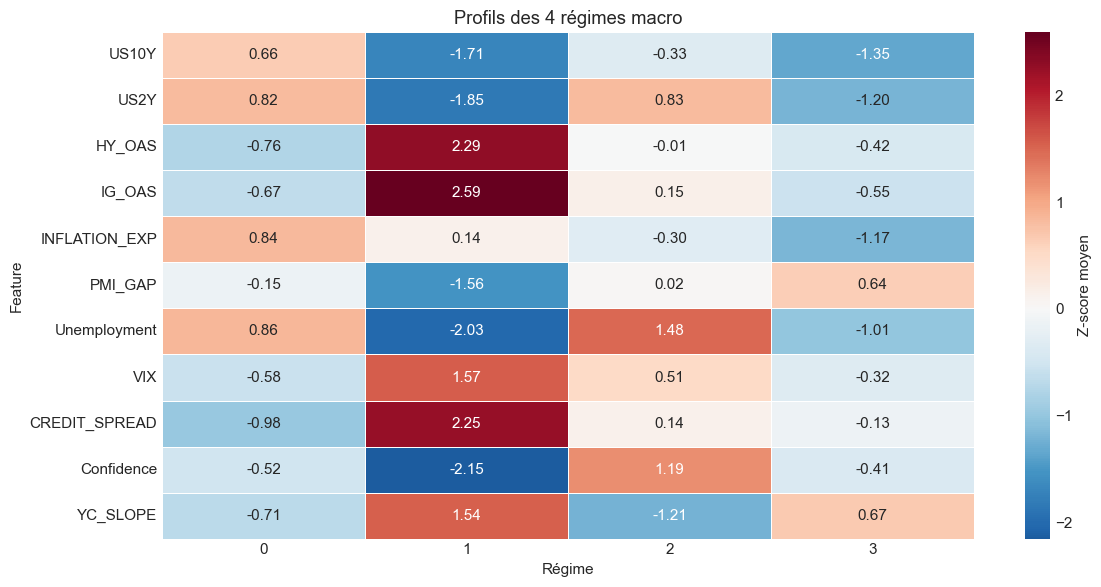

In [11]:
# Heatmap des profils
fig, ax = plt.subplots(figsize=(12, 6))

sns.heatmap(
    regime_profiles.T,
    cmap='RdBu_r',
    center=0,
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    ax=ax,
    cbar_kws={'label': 'Z-score moyen'}
)

ax.set_xlabel('Régime')
ax.set_ylabel('Feature')
ax.set_title(f'Profils des {K_OPTIMAL} régimes macro')
plt.tight_layout()
plt.show()


In [12]:
# Interprétation automatique des régimes
def interpret_regime(profile: pd.Series) -> str:
    """Interprète un profil de régime."""
    signals = []
    
    if profile.get('VIX', 0) > 1:
        signals.append("🔴 Stress élevé")
    elif profile.get('VIX', 0) < -0.5:
        signals.append("🟢 Faible volatilité")
    
    if profile.get('HY_OAS', 0) > 1:
        signals.append("💰 Spreads crédit larges")
    elif profile.get('HY_OAS', 0) < -0.5:
        signals.append("💰 Spreads crédit serrés")
    
    if profile.get('YC_SLOPE', 0) < -1:
        signals.append("📉 Courbe inversée")
    elif profile.get('YC_SLOPE', 0) > 1:
        signals.append("📈 Courbe pentue")
    
    if profile.get('PMI_GAP', 0) < -1:
        signals.append("🏭 PMI en contraction")
    elif profile.get('PMI_GAP', 0) > 1:
        signals.append("🏭 PMI en expansion")
    
    if profile.get('Confidence', 0) < -1:
        signals.append("😟 Confiance faible")
    elif profile.get('Confidence', 0) > 1:
        signals.append("😊 Confiance élevée")
    
    return ' | '.join(signals) if signals else "⚪ Neutre"

print("\n🏷️ Interprétation des régimes:")
print("=" * 60)
for regime in range(K_OPTIMAL):
    profile = regime_profiles.loc[regime]
    interpretation = interpret_regime(profile)
    count = (df_baseline['regime'] == regime).sum()
    pct = count / len(df_baseline) * 100
    print(f"\nRégime {regime} ({count} mois, {pct:.1f}%):")
    print(f"  {interpretation}")



🏷️ Interprétation des régimes:

Régime 0 (106 mois, 29.5%):
  🟢 Faible volatilité | 💰 Spreads crédit serrés

Régime 1 (46 mois, 12.8%):
  🔴 Stress élevé | 💰 Spreads crédit larges | 📈 Courbe pentue | 🏭 PMI en contraction | 😟 Confiance faible

Régime 2 (123 mois, 34.3%):
  📉 Courbe inversée | 😊 Confiance élevée

Régime 3 (84 mois, 23.4%):
  ⚪ Neutre


## 5. Timeline des régimes


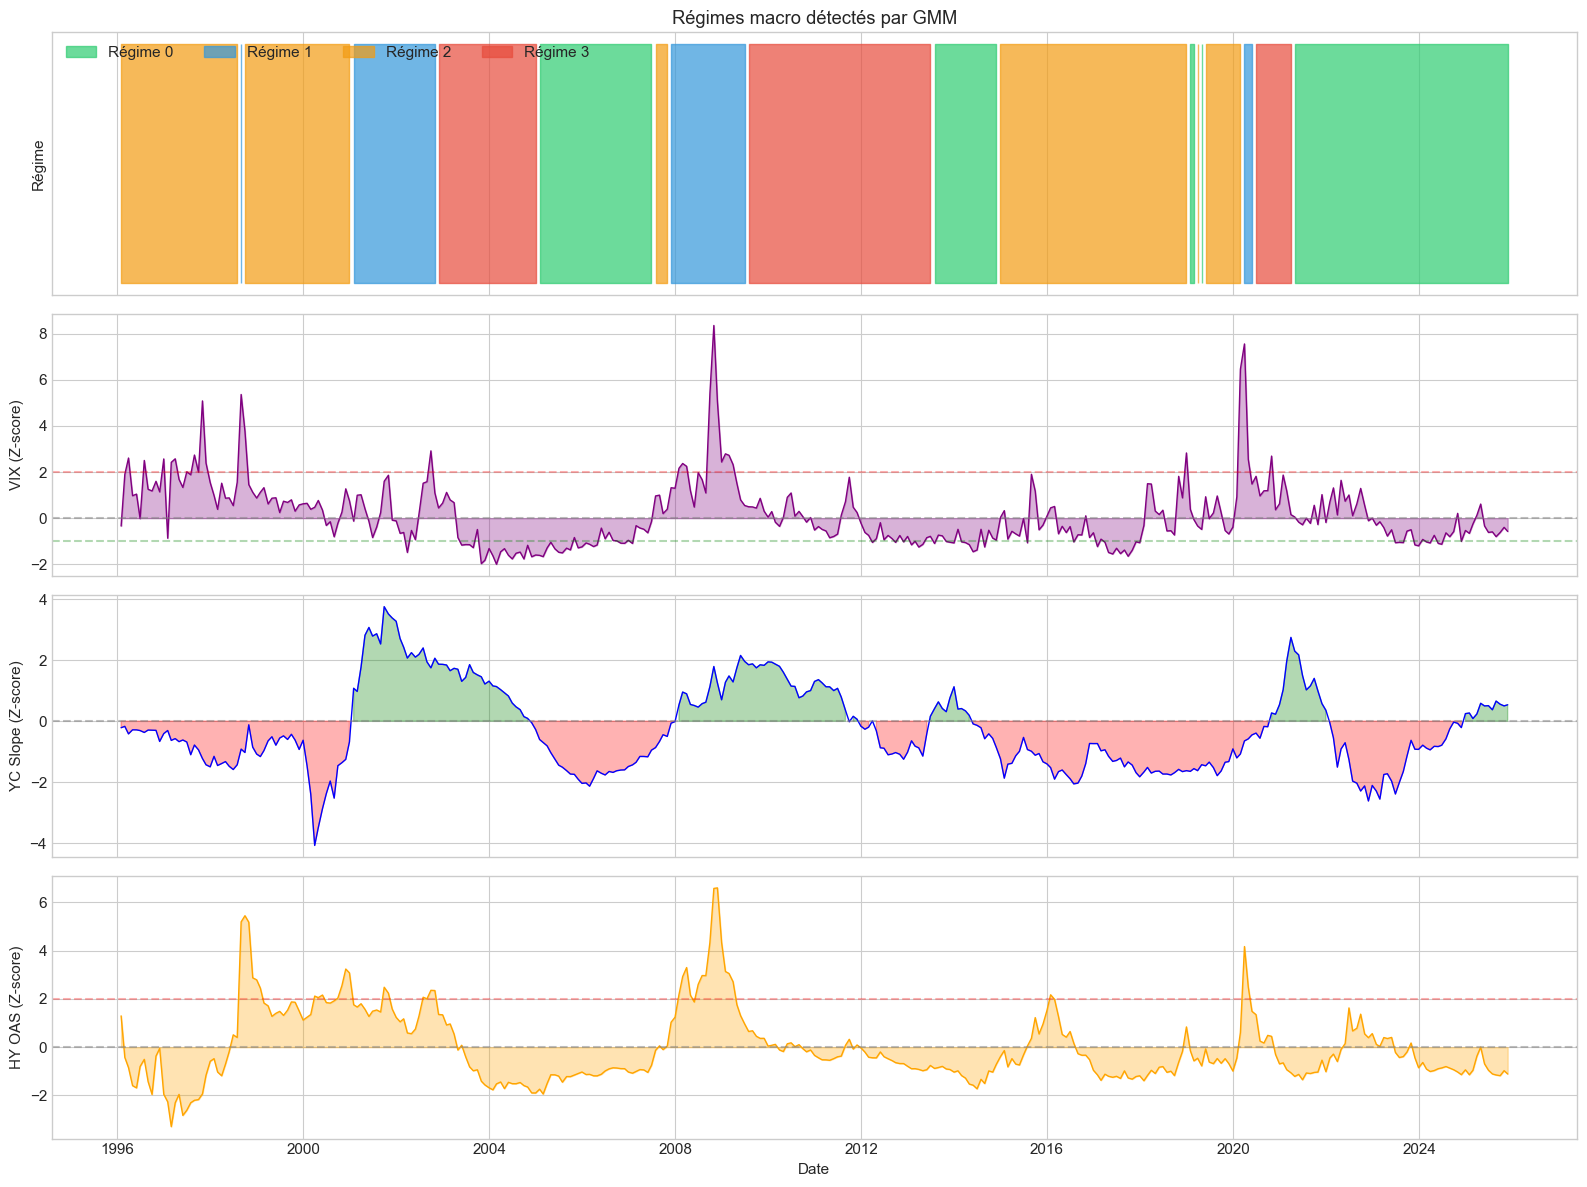

In [13]:
# Palette de couleurs pour les régimes
colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c', '#9b59b6', '#1abc9c']

fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)

# 1. Régimes
ax = axes[0]
for regime in range(K_OPTIMAL):
    mask = df_baseline['regime'] == regime
    ax.fill_between(df_baseline.index, 0, 1, where=mask, alpha=0.7, 
                    color=colors[regime], label=f'Régime {regime}')
ax.set_ylabel('Régime')
ax.set_yticks([])
ax.legend(loc='upper left', ncol=K_OPTIMAL)
ax.set_title('Régimes macro détectés par GMM')

# 2. VIX Z-score
ax = axes[1]
ax.plot(df_baseline.index, df_baseline['VIX_Z'], color='purple', linewidth=1)
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.axhline(2, color='red', linestyle='--', alpha=0.3)
ax.axhline(-1, color='green', linestyle='--', alpha=0.3)
ax.set_ylabel('VIX (Z-score)')
ax.fill_between(df_baseline.index, df_baseline['VIX_Z'], 0, alpha=0.3, color='purple')

# 3. Yield Curve Slope
ax = axes[2]
ax.plot(df_baseline.index, df_baseline['YC_SLOPE_Z'], color='blue', linewidth=1)
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.fill_between(df_baseline.index, df_baseline['YC_SLOPE_Z'], 0, 
                where=df_baseline['YC_SLOPE_Z'] >= 0, alpha=0.3, color='green')
ax.fill_between(df_baseline.index, df_baseline['YC_SLOPE_Z'], 0, 
                where=df_baseline['YC_SLOPE_Z'] < 0, alpha=0.3, color='red')
ax.set_ylabel('YC Slope (Z-score)')

# 4. HY Spreads
ax = axes[3]
ax.plot(df_baseline.index, df_baseline['HY_OAS_Z'], color='orange', linewidth=1)
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.axhline(2, color='red', linestyle='--', alpha=0.3)
ax.fill_between(df_baseline.index, df_baseline['HY_OAS_Z'], 0, alpha=0.3, color='orange')
ax.set_ylabel('HY OAS (Z-score)')
ax.set_xlabel('Date')

plt.tight_layout()
plt.show()


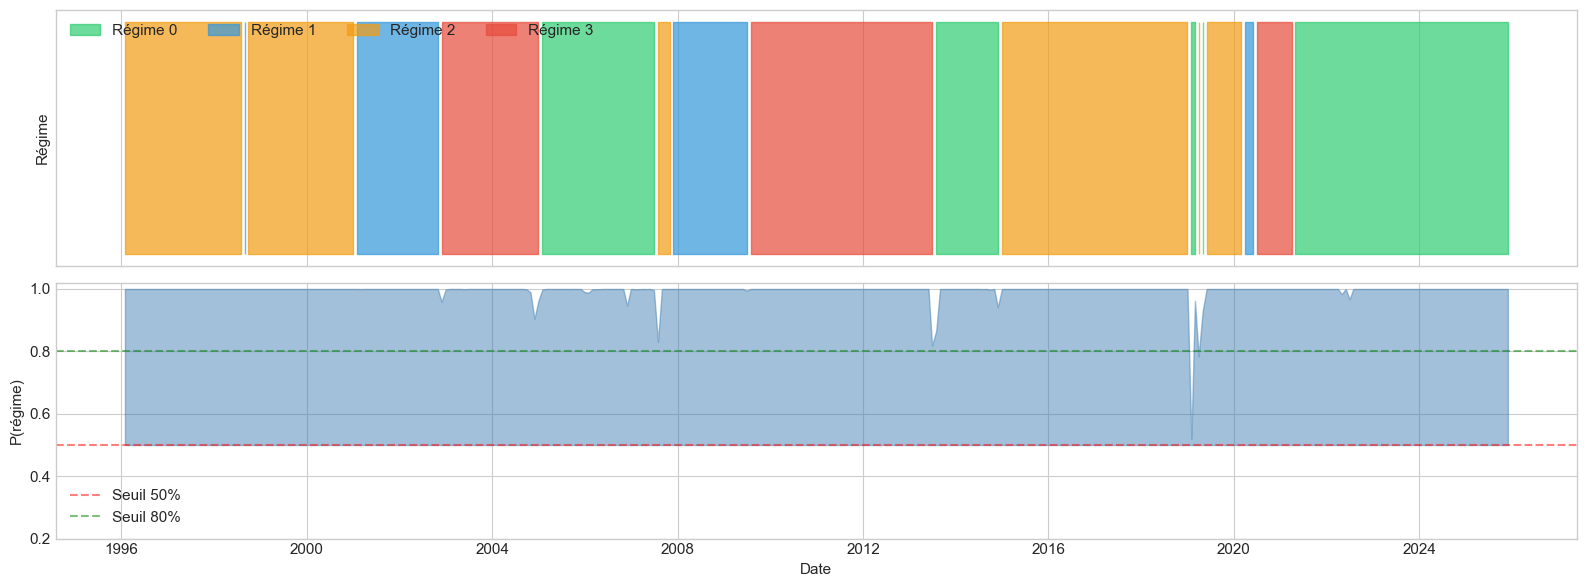

In [14]:
# Régimes avec confiance (probabilité)
fig, axes = plt.subplots(2, 1, figsize=(16, 6), sharex=True)

ax = axes[0]
for regime in range(K_OPTIMAL):
    mask = df_baseline['regime'] == regime
    ax.fill_between(df_baseline.index, 0, 1, where=mask, 
                    alpha=0.7, color=colors[regime], label=f'Régime {regime}')
ax.set_ylabel('Régime')
ax.set_yticks([])
ax.legend(loc='upper left', ncol=K_OPTIMAL)

ax = axes[1]
ax.fill_between(df_baseline.index, df_baseline['regime_proba'], 0.5, alpha=0.5, color='steelblue')
ax.axhline(0.5, color='red', linestyle='--', alpha=0.5, label='Seuil 50%')
ax.axhline(0.8, color='green', linestyle='--', alpha=0.5, label='Seuil 80%')
ax.set_ylabel('P(régime)')
ax.set_xlabel('Date')
ax.set_ylim(0.2, 1.02)
ax.legend()

plt.tight_layout()
plt.show()


## 6. Analyse des transitions


In [15]:
# Compter les transitions (matrice empirique)
regimes = df_baseline['regime'].values
transitions = pd.crosstab(
    pd.Series(regimes[:-1], name='from'),
    pd.Series(regimes[1:], name='to'),
    normalize='index'
)

print("Matrice de transition empirique (GMM):")
transitions


Matrice de transition empirique (GMM):


to,0,1,2,3
from,,,,
0,0.961905,0.000000,0.038095,0.000000
1,0.000000,0.913043,0.021739,0.065217
2,0.016260,0.032520,0.951220,0.000000
3,0.035714,0.000000,0.000000,0.964286


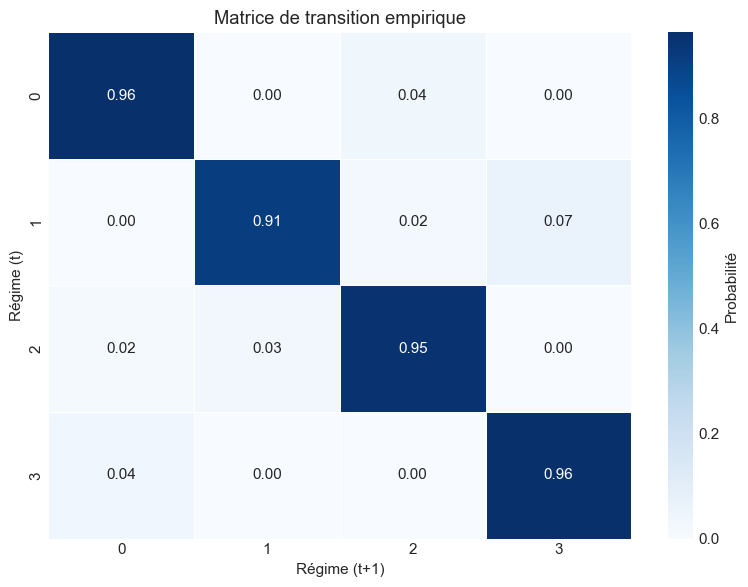


📊 Persistance des régimes:
  Régime 0: 96.2% (durée moyenne: 26.2 mois)
  Régime 1: 91.3% (durée moyenne: 11.5 mois)
  Régime 2: 95.1% (durée moyenne: 20.5 mois)
  Régime 3: 96.4% (durée moyenne: 28.0 mois)


In [16]:
# Heatmap transitions
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    transitions, cmap='Blues', annot=True, fmt='.2f',
    linewidths=0.5, ax=ax, cbar_kws={'label': 'Probabilité'}
)

ax.set_xlabel('Régime (t+1)')
ax.set_ylabel('Régime (t)')
ax.set_title('Matrice de transition empirique')
plt.tight_layout()
plt.show()

# Persistance des régimes
persistence = np.diag(transitions)
print("\n📊 Persistance des régimes:")
for i, p in enumerate(persistence):
    print(f"  Régime {i}: {p:.1%} (durée moyenne: {1/(1-p+1e-6):.1f} mois)")


## 7. Export des résultats


In [17]:
# Sauvegarder les régimes
output_path = ROOT / "data/features/gmm_regimes.parquet"
df_baseline.to_parquet(output_path)
print(f"✅ Régimes sauvegardés: {output_path}")

# Sauvegarder les profils
profiles_path = ROOT / "reports/regime_profiles.csv"
regime_profiles.to_csv(profiles_path)
print(f"✅ Profils sauvegardés: {profiles_path}")


✅ Régimes sauvegardés: /Users/etienne/Documents/Git/macro-dynamics/data/features/gmm_regimes.parquet
✅ Profils sauvegardés: /Users/etienne/Documents/Git/macro-dynamics/reports/regime_profiles.csv


## 📋 Résumé

**À retenir:**
1. K optimal trouvé par BIC/AIC
2. Profils économiques interprétables
3. Persistance des régimes mesurée
4. Prêt pour HMM (notebook suivant) qui modélisera mieux la dynamique temporelle
